# Classifying Text (e.g., newsgroups)

We'll step through a reasonably complete ML workflow and test the accuracy of a few of the ML algorithms we've discussed in class on the [20 newsgroups]( http://qwone.com/~jason/20Newsgroups) data set using [nltk](http://nltk.org/) and [scikit-learn](http://scikit-learn.org/).

By default, nltk only includes a small sample of the 20 newsgroups data, so for this demo you'll need to download the complete collection of texts, from [here](http://people.csail.mit.edu/jrennie/20Newsgroups/20news-18828.tar.gz).

Shamelessly adapted from:
http://nbviewer.ipython.org/urls/dl.dropboxusercontent.com/u/4864294/ML/20%2520newsgroups.ipynb

## Import data

Once you've downloaded and uncompressed the collection, you should have a folder called '20news-18828' in your current directory.  We can now use set up nltk's corpus tools to allow us to easily access the text. 

In [1]:
import nltk
newsgroups = \
  nltk.corpus.PlaintextCorpusReader('/Users/jbloom/Downloads/20news-18828', '.*/[0-9]+', encoding='latin1')

An nltk corpus can be viewed as a collection of files:

In [2]:
ids = newsgroups.fileids()
print(len(ids))
ids[::4000]

18828


['alt.atheism/49960',
 'comp.sys.mac.hardware/51628',
 'rec.motorcycles/104509',
 'sci.electronics/53771',
 'talk.politics.guns/54514']

In [3]:
!cat /Users/jbloom/Downloads/20news-18828/sci.electronics/53771

From: levy@levy.fnal.gov (Mark E. Levy, ext. 8056)
Subject: Sources for Intel D87C51FB?

I am in the midst of designing a project which requires two motors and an LED
illuminator driven with Pulse-width modulation.  I'm using the 8751, and
I understand that the -FB version has a programmable counter array that can
essentially be set and forgotten to do the PWM.  The problems is, that variant
is difficult to come by.  I need two or three of the D prefix (ceramic window)
version for development, and then lots of the P prefix (plastic OTP) for later
production.  I've tried Avnet, Arrow, and Pioneer.  They (might) have them, but
I'm looking for samples at this point, and they're not too willing to provide
them.  I would buy them, but these vendors have $100.00 minimums.

Any help is appreciated.

[ Mark E. Levy, Fermilab          |                                            ]
[ BitNet:   LEVY@FNAL             | Unix is to computing                       ]
[ Internet: LEVY@FNALD.FNAL.GOV   

We'll take the list of file ids, randomly shuffle it, and divide it into training and test sections.  And, to make the demo go faster, we'll only use a small sample of the available text.

In [4]:
import random

random.seed(0)

random.shuffle(ids)
ids = ids[:5000]
size = len(ids)

testSet = ids[:int(size*0.1)]
trainSet = ids[int(size*0.1):]

print(len(trainSet), len(testSet))

4500 500


## Extract features

Now that we've got our data, we need to convert our newsgroup texts into features that can be used by machine learning algorithms.  For this example, we'll use lexical features: each word is a feature, and it's value is the number of times that word occurs in a text. 



In [5]:
from collections import defaultdict

def features(text):
    """Convert a post into a dictionary of features"""
    features = defaultdict(int)
    for word in text:
        if word.isalpha():
            features[word.lower()] += 1
    return features

print(features(newsgroups.words(fileids=trainSet[0])))

defaultdict(<class 'int'>, {'unintentional': 1, 'haganah': 1, 'since': 1, 'odd': 1, 'down': 1, 'seen': 1, 'testimony': 2, 'stupidly': 1, 'given': 2, 'be': 1, 'extremists': 1, 'whom': 1, 'pale': 1, 'pictures': 2, 'didn': 1, 'him': 1, 'people': 1, 'photographer': 1, 'soldier': 1, 'see': 2, 'any': 2, 'nothing': 2, 'dir': 3, 'if': 2, 'deposited': 1, 'ca': 2, 'ere': 2, 'remember': 1, 'is': 4, 'historian': 1, 't': 4, 'hassan': 1, 'martinb': 1, 'askew': 3, 'no': 10, 'you': 7, 'remote': 1, 'hundreds': 1, 'before': 1, 'hands': 1, 'why': 1, 'sound': 1, 'proud': 1, 'had': 3, 'to': 17, 'surviving': 1, 'credible': 1, 'writes': 2, 'somehow': 1, 'really': 2, 'on': 3, 'head': 2, 'likud': 1, 'a': 12, 'have': 3, 'own': 3, 'want': 3, 'which': 1, 'for': 6, 'absolutely': 1, 'stern': 1, 'has': 1, 'brise': 1, 'van': 1, 'brown': 2, 'brenda': 1, 'adelaide': 2, 'government': 3, 'gotten': 1, 'sue': 1, 'deir': 1, 'grief': 1, 'arab': 4, 'israeli': 1, 'exactly': 1, 'else': 3, 'source': 2, 'ethnic': 1, 'now': 1, 'si

We'll also extract the class names for training instances.  For the class, we'll just use the name of the newsgroup that the text was taken from, and we can get that from the first part of the fileid.

In [6]:
def getclass(fileid):
    """Get class name from fileid"""
    return fileid.split('/')[0]

print(getclass(trainSet[0]))

talk.politics.mideast


Finally, we'll apply these functions to all the posts in the dataset (this may a while!)

In [7]:
%time trainData = [(features(newsgroups.words(fileids=f)),getclass(f)) for f in trainSet]

CPU times: user 5.74 s, sys: 1.43 s, total: 7.17 s
Wall time: 14.6 s


In [8]:
%time testData = [(features(newsgroups.words(fileids=f)),getclass(f)) for f in testSet]

CPU times: user 732 ms, sys: 176 ms, total: 908 ms
Wall time: 1.88 s


In [9]:
trainData[0]

(defaultdict(int,
             {'a': 12,
              'absolutely': 1,
              'absurd': 1,
              'actually': 1,
              'adelaide': 2,
              'admitted': 1,
              'agree': 1,
              'all': 5,
              'almost': 1,
              'am': 1,
              'and': 12,
              'angell': 1,
              'any': 2,
              'anymore': 1,
              'anyone': 1,
              'arab': 4,
              'arabs': 1,
              'archives': 2,
              'are': 2,
              'aren': 1,
              'armed': 1,
              'article': 2,
              'as': 4,
              'askew': 3,
              'asserts': 1,
              'at': 3,
              'attack': 1,
              'attacked': 3,
              'au': 1,
              'aurag': 2,
              'autumn': 1,
              'back': 1,
              'backs': 1,
              'be': 1,
              'because': 1,
              'before': 1,
              'begin': 2,
             

## Baseline

Now that we've got all our posts converted into features and classes, we can try building some classifiers.  First, we'll establish a baseline score: how accurate is a classifier that assigns the most frequent class to every instance?

In [10]:
list(c.keys())

NameError: name 'c' is not defined

In [12]:
c = nltk.FreqDist(item[1] for item in trainData)
default = list(c.keys())[0]
print(c)

<FreqDist with 20 samples and 4500 outcomes>


In [13]:
sum(c==default for f,c in testData) / float(len(testData))

0.068

## Naive Bayes

Next, we can try a few variations on the Naive Bayes classifier.  Nltk includes a simple function for training Naive Bayes classifiers which is very easy to use, though slow and not very accurate.

In [14]:
nb = nltk.NaiveBayesClassifier.train(trainData)

Nltk also provides easy tools for evaluating classifiers.

In [15]:
print(nltk.classify.accuracy(nb, testData))

0.654


Nltk also has functions that allow us to call other machine learning libraries, including scikit-learn, using wrapper classes.

In [16]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import BernoulliNB

bernoulli = SklearnClassifier(BernoulliNB())
bernoulli.train(trainData)

print(nltk.classify.accuracy(bernoulli, testData))

0.496


In [17]:
from sklearn.naive_bayes import MultinomialNB

multi = SklearnClassifier(MultinomialNB())
multi.train(trainData)

print(nltk.classify.accuracy(multi, testData))

0.75


Scikit-learn includes functions for performing feature selection and error analysis.

In [18]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('chi2', SelectKBest(chi2, k=1000)),
                     ('nb', MultinomialNB())])

pmulti = SklearnClassifier(pipeline)
pmulti.train(trainData)

print(nltk.classify.accuracy(pmulti, testData))

0.694


## Support Vector Machines

We can use any of the learning algorithms implemented by scikit-learn ([decision trees](http://scikit-learn.org/stable/modules/tree.html#classification), [knn](http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification), maxent [aka [logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)], [adaboost](http://scikit-learn.org/stable/modules/ensemble.html#adaboost), [linear](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn-svm-linearsvc) and [non-linear](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn-svm-svc) SVMs, etc) in the same way.

In [19]:
from sklearn.svm import LinearSVC

svm = SklearnClassifier(LinearSVC())
svm.train(trainData)

print(nltk.classify.accuracy(svm, testData))

0.782


In [20]:
results = svm.classify_many(item[0] for item in testData)
results[0], testData[0][1]

('comp.windows.x', 'comp.windows.x')

In [21]:
from sklearn.metrics import confusion_matrix

[[18  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0]
 [ 1 16  0  1  2  0  0  0  0  0  0  0  3  1  0  0  0  0  0  0]
 [ 0  1 22  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  1  0]
 [ 0  1  2 18  1  2  0  1  0  0  0  1  0  2  0  0  0  0  0  0]
 [ 0  2  1  1 16  0  0  0  1  0  0  0  2  1  0  0  0  1  0  0]
 [ 0  3  1  2  3 16  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  1  0  1  1  0  0  1  0  0  0  0  0]
 [ 0  2  0  1  0  0  0 15  0  0  0  0  0  1  0  0  0  0  1  1]
 [ 0  1  0  0  0  0  0  0 30  0  0  0  0  1  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  1  1 28  0  0  1  0  0  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  2 22  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0 20  0  0  0  0  0  0  0  0]
 [ 0  2  1  1  2  1  1  2  0  0  0  0 25  0  0  0  0  0  0  0]
 [ 0  2  0  1  1  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0  0 26  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0 19  0  0

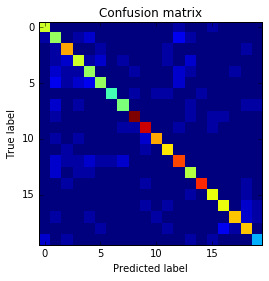

In [22]:
# Compute confusion matrix
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

cmm = confusion_matrix([x[1] for x in testData], results)

print(cmm)
cmm = np.array(cmm,dtype=np.float)
print(cmm.shape)

f,ax = plt.subplots()

# Show confusion matrix in a separate window
ax.imshow(cmm,interpolation='nearest')
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
